In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image 
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const

from causticpy import *
from functions_caustic import to_xyz_coordinates, linear_angle, data_query_id

 У нас имеются таблицы с данными каталогов:
- **SDSS (glist_s)**, 
- **2MRS (glist_2)**.
 
**SDSS** - *Sloan Digital Sky Survey* с англ. — «Слоуновский цифровой небесный обзор») — проект широкомасштабного исследования многоспектральных изображений и спектров красного смещения звёзд и галактик при помощи 2,5-метрового широкоугольного телескопа в обсерватории Апачи-Пойнт в штате Нью-Мексико. Проект назван в честь фонда Альфреда Слоуна.

Исследования начались в 2000 году, в ходе работы проекта было проведено картографирование более 35 % небесной сферы с фотометрическими наблюдениями порядка 500 миллионов объектов и получением спектров более чем для 3 миллионов объектов. Среднее значение красного смещения по изображениям галактик составило 0.1; для ярких красных галактик вплоть до z=0,4, для квазаров до z=5. Наблюдения в рамках обзора способствовали обнаружению квазаров со сдвигом более 6.

Проект делится на несколько фаз: SDSS-I (2000—2005), SDSS-II (2005—2008), SDSS-III (2008—2014), SDSS-IV (2014—2020). Собранные в ходе обзоров данные публикуются в виде отдельных релизов (Data Release), последний из них, DR13 опубликован в августе 2016 года.

**2MASS Redshift Survey** -  aims to map the distribution of galaxies and dark matter in the local universe, out to a mean redshift of z = 0.03 (roughly equivalent to 115 Mpc or 370 million light-years). It is based on galaxy selection in the near infra-red from the *Two Micron All-Sky Survey* (**2MASS**). 2MASS has now mapped all of the sky in the near infra-red J, H and K-bands. This photometric survey is complete and fully available to the public (IRSA). The 2MASS extended source catalog (XSC) includes roughly half a million galaxies to a limiting K magnitude of K=13.5 mag. 2MRS ultimately aims to determine the redshifts of all galaxies in the XSC to a magnitude of K=12.2 mag (about 100,000 galaxies) and to within 5 deg of the Galactic plane. The second phase of 2MRS is now complete, providing an all-sky survey of 45,000 galaxies with redshifts to a limiting magnitude of K=11.75 mag. It is the densest sampled all-sky redshift survey to date and its selection in the near infra-red reduces the impact of the zone of avoidance (where the plane of our own Galaxy obscures extragalactic objects). 2MRS provides complementary redshift information to deeper surveys like SDSS and the 2dFRGS which cover much smaller fractions of the sky. It improves on the IRAS redshift survey IRAS PSCz which was not able to distinguish galaxies in regions of high density (ie. clusters).

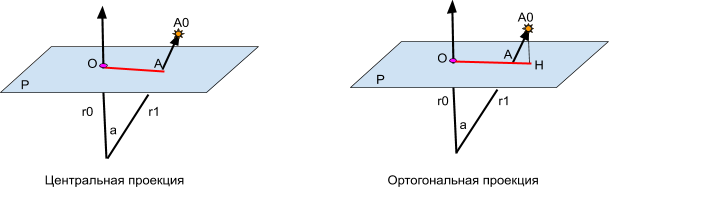

In [2]:
Image("projections.png") 

В астрофизике принято рассматривать небесные объекты в проекции на небесную сферу.    

Предполагается, что наблюдатель располагается в вершине угла $a$.
на рисунке обозначено:

$O$ - центр некоторого скопления,

$A_0$ - некоторая галактика из скопления,

$r_0$ - вектор, соединяющий глаз наблюдателя и центр скопления $O$,

$r_1$ - вектор, соединяющий глаз наблюдателя и объект $A_0$,

$P$ - плоскость построенная таким образом, что она перпендикулярна вектору   $r_0$ и проходит через центр скопления $O$,

$A$ - точка пересечения луча, идущего из глаза наблюдателя через объект $А_0$ с плоскостью $P$,

$H$ - перпендикуляр, опущенный из из  $A_0$ на плоскость $H$,

$a$ - линейный угол между векторами $r_0$ и $r_1$,

красные отрезки $OA(OH)$ -  проекции на плоскость Р.

###### Так как наблюдения проводятся из одной точки, то интересующая нас проекция - центральная. 

Поскольку данные об углах  right ascention (RAJ2000) и declination (DEJ2000) указаны в градусах, а вычислениях мы будем пользоваться радианами, то с помощью формулы перейдем от одних единиц измерения к другим:

\begin{equation}
\alpha_{rad} = \pi \frac{\alpha_{grad}}{180}
\end{equation}

Через данные об углах наклонения (DEC=DEJ2000) и вознесения (RA=RAJ2000) вычисляются координаты соответствующего объекта на единичной сфере:

 \begin{equation}
\left\{ \begin{array}{ll}
    x = \cos(DEC)\cos(RA) \\
    y = \cos(DEC)\sin(RA)\\
    z = \sin(DEC)
\end{array} \right.
\end{equation}

Далее необходимо вычислить длинну проекции $OA$  для каждой галактики из соответствующего скопления по всем скоплениям с помощью формулы: 

\begin{equation}
     r_{pr} = r_0 \tan(a),
\end{equation}

где угол $а$ - линейный угол между лучами, соединяющими наблюдателя с галактикой в скоплении и наблюдателя с центром скопления. Зная углы наклонения (DEC=DEJ2000) и вознесения (RA=RAJ2000), можно вычислить тангенс угла $а$:

 \begin{equation}
\left\{ \begin{array}{ll}
    x = \cos(DEC)\cos(RA) \\
    y = \cos(DEC)\sin(RA)\\
    z = \sin(DEC)
\end{array} \right.
\end{equation}

\begin{equation}
\cos(a) = x_{centr}x_{gal} + y_{centr}y_{gal}+z_{centr}z_{gal}
\end{equation}

\begin{equation}
\tan(a) = \frac{\sqrt{1-\cos^2(a)}}{\cos(a)}
\end{equation}

Введем используемые в дальнейшем исследовании космологические постоянные:

Скорости галактик в скоплении относительно центра этого скопления высчитывались с помощью формулы: 

\begin{equation}
    v = c * (z_{gal} - z_{cent})
\end{equation}

Отметим, что все эти скорости могут вычислены только вдоль луча зрения (line-of-sight) на основании измерений красного смещения (red shift)  $z$ рассматриваемого объекта. Поперечные скорости определить сложно, так как время съемки телескопом данного участка неба по сравнению с перемещением объекта по небесной сфере ничтожно мало, а потому увидеть какие-то видимые измения в положении объекта на небе пока не представляется возможным.

Далее воспользуемся программой 'Caustic mass estimator for astrophysical systems', взятой с репозитория  Dan Gifford на GitHub http://github.com/giffordw . Данная программа позволяет на основе данных об углах   RA, DEC и красного смещения z строить каустические кривые для скоплений галактик. Программный код основывается на методах, описанных в статьях:
- A.Diafferio. Mass estimation in the outer regions of galaxy clusters. 1999.
- Gifford et al. A Systematic Analysis of Caustic Methods for Galaxy Cluster Masses. 2013.
- Gifford & Miller. Velocity Anisotropy and Shape Bias in the Caustic Technique. 2013.

Каустики - это некие кривые в фазовой плоскости (r,v), которые разделяют эту плоскость на несколько сегметов: центральный, нижний и верхний. Из взаимного положения галактик в коплении и соответствующих каустик на фазовой плоскости можно судить о будующем этого скопления. Например, если галактики лежат вне центральной области, ограниченной каустиками, то можно заключить, что данная галактика в будущем покинет это скопление.

In [3]:
C = const.c.to('km/s') #300000  # km/s -  скорость света в вакууме
# Mpc = 3.086e+19 # km -  мегапарсек

In [4]:
data = pd.read_csv('glist_2.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 21 columns):
iGalID            1200 non-null int64
iGrID             1200 non-null int64
Name              1200 non-null object
RAJ2000_gal       1200 non-null float64
DEJ2000_gal       1200 non-null float64
z_gal             1200 non-null float64
logMstar_gal      425 non-null float64
RAJ2000_group     1200 non-null float64
DEJ2000_group     1200 non-null float64
z_group           1200 non-null float64
logLtot           1200 non-null float64
logLobs           1200 non-null float64
logMtot           1200 non-null float64
logMstar_group    1165 non-null float64
NMstar            1200 non-null int64
logMdyn           1200 non-null float64
sigma             1200 non-null float64
Rad               1200 non-null float64
angRad            1200 non-null float64
DL                1200 non-null float64
Ntot              1200 non-null int64
dtypes: float64(16), int64(4), object(1)
memory usage: 197.0+ K

In [6]:
# !pip install scikit-image

In [7]:
iGrID = data['iGrID'].unique()[0:1]

In [8]:
# data.columns

In [12]:
data_query = data_query_id(data, iGrID[0], 'iGrID')
galaxydata = data_query.to_numpy()

In [13]:
c = Caustic()
good_flag = c.run_caustic(galaxydata, 
                          clus_ra=galaxydata[:,3].mean(),
                          clus_dec=galaxydata[:,4].mean(),
                          clus_z=galaxydata[:,5].mean())#, r200=0.743, clus_ra=195.095, clus_dec=19.131,clus_z=0.063)

DATA SET SIZE 43
Pre_r200= 0.35374227608257586
Calculating Density w/Mirrored Data
Vdisp from galaxies= 118.4137724813458
Combined Vdisp= 118.4137724813458
Calculating initial surface
complete
r200 estimate:  0.2338076934627482
M200 estimate:  1550714469573.0642


In [14]:
data_query.columns

Index(['RAJ2000_gal', 'DEJ2000_gal', 'z_gal', 'RAJ2000_group', 'DEJ2000_group',
       'z_group', 'iGrID', 'DL', 'r_pr', 'v'],
      dtype='object')

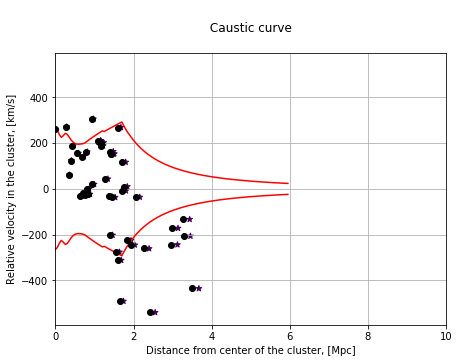

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
x_max = data_query['r_pr'].max()
y_max = abs(data_query['v']).max()
x = data_query['r_pr']
y = data_query['v'] 
ax.scatter(x, y, c=data_query['iGrID'], marker='*')
ax.plot(c.x_range, c.caustic_profile, c='red')
ax.plot(c.x_range, -c.caustic_profile, c='red')
ax.plot(c.r,c.v,'o', c='black')
ax.set_xlabel('Distance from center of the cluster, [Mpc]')
ax.set_ylabel('Relative velocity in the cluster, [km/s]')
ax.set_title('\n Caustic curve \n')
# ax.set_title('iGrID = %d' % (iGrID))
ax.set_ylim(top=y_max*1.1, bottom=-y_max*1.1)
ax.set_xlim((0,10))
ax.grid(True)
# plt.savefig("caustic.png")

In [16]:
# Image("caustic.png") 

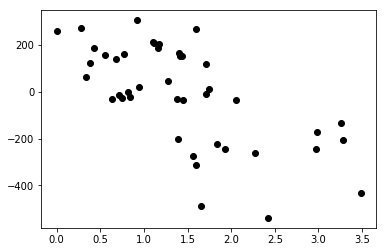

In [17]:
from pylab import *
plot(c.r,c.v,'o', c='black')
# plt.savefig("caustic.png")
# Image("caustic.png") 

In [18]:
# Проверить почему не работает???

# plot(data[data['iGrID']==iGrID]['r_pr'],data[data['iGrID']==iGrID]['v'],'o', c='black')
# show()

Понять как они определяют расстояния. Очевидно, что немного по-другому. Это может быть причиной различия в оцененных массах на основе каустик и Mtot из таблиц.

To make two pictures made above look simular we made same changes in the 
- file "\__init\__"
- in class Caustic
- in function run_caustic
- in function findangle(self,ra,dec,clus_RA,clus_DEC)

Because with a previous code a projected radius was calculated another way.

In [19]:
m = MassCalc(ri = c.x_range,
    A = c.caustic_profile,
    vdisp = c.vdisp_gal,
    clus_z = galaxydata[:,5].mean(),
    r200=2.0,
    conc1=5,
    beta=0.25,
    fbr=None,
    H0=100.0,)

In [20]:
m.M200

17403720159393.834

In [21]:
12427715478374.973 # for native radius calculatiouns
12427715478374.607 # data[data['iGrID']==iGrID]['sigma'].mean()
12427715478374.607 # for c.vdisp_gal

12427715478374.607

Let's put caustic profile onto the galaxy cluster in a phase space